In [1]:
!pip install fastprogress

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import string

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from fastprogress import master_bar, progress_bar

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data preprocessing

In [3]:
train_df = pd.read_csv("data/fl_2022_FullName_train.csv.gz")
val_df = pd.read_csv("data/fl_2022_FullName_val.csv.gz")
test_df = pd.read_csv("data/fl_2022_FullName_test.csv.gz")

In [4]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(7678780, 5)
(959847, 5)
(959848, 5)


## Creating Dataset

In [5]:
all_letters = string.ascii_letters + "'- "

In [6]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'- "

In [7]:
n_letters = len(all_letters)

In [8]:
n_letters

55

In [9]:
all_categories = train_df['race'].unique()

In [10]:
all_categories

array(['nh_white', 'nh_black', 'hispanic', 'asian', 'other'], dtype=object)

In [11]:
n_categories = len(train_df['race_code'].unique())

In [12]:
n_categories

5

In [13]:
max_name = train_df['full_name'].str.len().max()

In [14]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [15]:
letterToIndex(' ')

54

In [16]:
oob = n_letters + 1

In [17]:
torch.ones(5)

tensor([1., 1., 1., 1., 1.])

In [18]:
def lineToTensor(line):
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [19]:
lineToTensor('Jason')

tensor([35.,  0., 18., 14., 13., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])

In [20]:
print(lineToTensor('Jason').size())

torch.Size([47])


In [21]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, 3]
    if self.transform:
      name = self.transform(name)
    label = self.df.iloc[idx, 4]
    #target = getTarget(label)
    target = torch.tensor(label, dtype=torch.int64)
    return name, target

In [22]:
train_dataset = EthniColorDataset(train_df, lineToTensor)
val_dataset = EthniColorDataset(val_df, lineToTensor)
test_dataset = EthniColorDataset(test_df, lineToTensor)

In [23]:
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([27.,  0., 23., 11.,  0., 54., 41.,  7., 24., 11., 11.,  8., 18., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)
1 tensor([37., 20.,  3., 22.,  8., 13., 54., 43., 14., 13., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)
2 tensor([44.,  8.,  6., 13.,  4., 17., 54., 48.,  4., 11., 19., 14., 13., 54.,
        35.,  4., 18., 18.,  8.,  2.,  0., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)


In [24]:
# The Dataset retrieves our dataset’s features and labels one sample at a time. 
# While training a model, we typically want to pass samples in “minibatches”, 
# reshuffle the data at every epoch to reduce model overfitting, and 
# use Python’s multiprocessing to speed up data retrieval.

batch_size=128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)

In [25]:
next(iter(train_dataloader))

[tensor([[37.,  8., 13.,  ..., 56., 56., 56.],
         [38., 14., 17.,  ..., 56., 56., 56.],
         [31., 17., 14.,  ..., 56., 56., 56.],
         ...,
         [41., 11.,  4.,  ..., 56., 56., 56.],
         [31., 17.,  4.,  ..., 56., 56., 56.],
         [41., 14., 17.,  ..., 56., 56., 56.]]),
 tensor([1, 3, 0, 1, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 3, 3, 2, 0, 0, 0, 2, 3, 1, 0, 4, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 1, 0, 0, 4, 3, 1, 0, 3, 0, 0, 1,
         0, 0, 0, 3, 0, 0, 3, 2, 0, 3, 1, 1, 0, 0, 0, 3, 0, 4, 1, 3, 0, 0, 3, 0,
         0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 3, 0, 1, 0, 4, 1, 3, 0, 0, 0, 0,
         0, 0, 3, 0, 0, 0, 0, 3])]

In [26]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())
    if i_batch == 2:
        break

0 torch.Size([128, 47]) torch.Size([128])
1 torch.Size([128, 47]) torch.Size([128])
2 torch.Size([128, 47]) torch.Size([128])


In [27]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [28]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))  
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 128
seq_len = max_name 
vocab_size = n_letters + 2

rnn = LSTM(vocab_size, n_hidden, n_categories)
rnn.to(device)

LSTM(
  (embedding): Embedding(57, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [29]:
input = lineToTensor('Rogers Renee')

print(input)
print("input shape : ",input.shape)
print("input shape w batch : ", input.unsqueeze(0).shape)
#print(hidden.shape)

# sending with batch 1
output = rnn(input.unsqueeze(0).to(device))
# print(output) - has 47x8 log values
print(output.shape)

tensor([43., 14.,  6.,  4., 17., 18., 54., 43.,  4., 13.,  4.,  4., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
input shape :  torch.Size([47])
input shape w batch :  torch.Size([1, 47])
torch.Size([1, 5])


In [30]:
output

tensor([[-1.7276, -1.3896, -1.5448, -1.8923, -1.5653]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [31]:
torch.argmax(output)

tensor(1, device='cuda:0')

In [32]:
a = torch.zeros(1, 2, 3, 4, 5, 6)
b = a.view(*a.shape[:2], -1, *a.shape[5:])
print(a.shape)
print(b.shape)

torch.Size([1, 2, 3, 4, 5, 6])
torch.Size([1, 2, 60, 6])


In [33]:
a = torch.zeros(1,47,53,64)
b = a.view(a.shape[0],-1,a.shape[3])
print(a.shape)
print(b.shape)
c = torch.zeros([1, 2491, 256])
d = c.view(c.shape[0],47,53,c.shape[2])
print(d.shape)

torch.Size([1, 47, 53, 64])
torch.Size([1, 2491, 64])
torch.Size([1, 47, 53, 256])


In [34]:
top_n, top_i = output.topk(1)

In [35]:
output

tensor([[-1.7276, -1.3896, -1.5448, -1.8923, -1.5653]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [36]:
top_n

tensor([[-1.3896]], device='cuda:0', grad_fn=<TopkBackward0>)

In [37]:
top_n # has log values
top_i # has indices

tensor([[1]], device='cuda:0')

In [38]:
# to get best value
top_n, top_i = output.topk(1)
category_i = top_i[0].item()
all_categories[category_i], category_i

('nh_black', 1)

## Training


In [39]:
device

device(type='cuda', index=0)

In [40]:
!lscpu | grep -i cpu

CPU op-mode(s):                  32-bit, 64-bit
CPU(s):                          30
On-line CPU(s) list:             0-29
CPU family:                      25
CPU MHz:                         2449.998
NUMA node0 CPU(s):               0-29
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm rep_good nopl cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy svm cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw perfctr_core invpcid_single ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 xsaves clzero xsaveerptr wbnoinvd arat npt nrip_save umip pku ospke vaes vpclmulqdq rdpid fsrm arch_capabilities


In [41]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

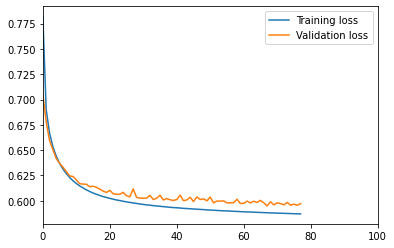

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 0.705395).  Saving model ...


/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (0.705395 --> 0.678182).  Saving model ...
Validation loss decreased (0.678182 --> 0.659533).  Saving model ...
Validation loss decreased (0.659533 --> 0.650431).  Saving model ...
Validation loss decreased (0.650431 --> 0.641645).  Saving model ...
Validation loss decreased (0.641645 --> 0.637123).  Saving model ...
Validation loss decreased (0.637123 --> 0.633236).  Saving model ...
Validation loss decreased (0.633236 --> 0.629000).  Saving model ...
Validation loss decreased (0.629000 --> 0.624543).  Saving model ...
Validation loss decreased (0.624543 --> 0.623953).  Saving model ...
Validation loss decreased (0.623953 --> 0.620641).  Saving model ...
Validation loss decreased (0.620641 --> 0.616841).  Saving model ...
Validation loss decreased (0.616841 --> 0.616427).  Saving model ...
Validation loss decreased (0.616427 --> 0.616293).  Saving model ...
Validation loss decreased (0.616293 --> 0.613829).  Saving model ...
Validation loss decreased (0.61382

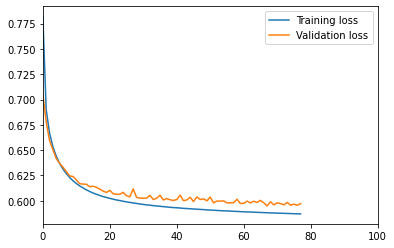

In [42]:
epochs = 100
lr = 0.0001 # 0.005 is very slow


# CrossEntropyLoss expects raw prediction values while NLLLoss expects log probabilities.
# criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
# since we are using nn.LogSoftmax as final layer at model  
criterion = nn.NLLLoss()

optimizer = AdamW(rnn.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


early_stopper = EarlyStopper(patience=10)


mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 1000

for epoch in mb:
  x.append(epoch)
  # Train
  i = 0
  rnn.train()
  total_loss = torch.Tensor([0.0]).to(device)
  for batch in progress_bar(train_dataloader, parent=mb):
    rnn.zero_grad()
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    # backward propagation
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    #torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()
    with torch.no_grad():
      total_loss += loss.item()
    i += 1
    #if i == till_batch:
    #  break

  # decay lr
  #scheduler.step()

  mean = total_loss / len(train_dataloader)
  #mean = total_loss / till_batch
  training_losses.append(mean.cpu())

  # Evaluate
  i = 0
  rnn.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_dataloader, parent=mb):
      input = batch[0].to(device)
      label = batch[1].to(device)
      output = rnn(input)
      loss = criterion(output, label)
      validation_loss += loss.item()
      i += 1
      #if i == till_batch:
      #  break

  val_mean = validation_loss / len(val_dataloader)
  #val_mean = validation_loss / till_batch 
  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(rnn.state_dict(), 'simple_rnn_ethni.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):             
      break

## Save Model

In [44]:
torch.save(rnn.state_dict(), 'lstm_FullName_pytorch.pt')

Text(0, 0.5, 'loss')

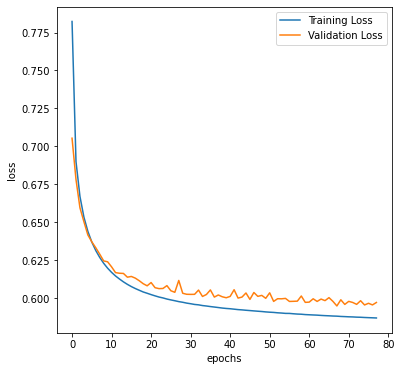

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, training_losses, validation_losses)
ax.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("epochs")
plt.ylabel("loss")

In [46]:
# last epoch losses
print(training_losses[-1])
print(validation_losses[-1])

tensor([0.5870])
tensor([0.5972])


## Testing

In [47]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [48]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix    
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

Testing: 100%|██████████| 7498/7498 [01:42<00:00, 72.82it/s]


              precision    recall  f1-score   support

       asian       0.81      0.78      0.80    169034
    hispanic       0.36      0.06      0.10     40188
    nh_black       0.73      0.62      0.67    149283
    nh_white       0.82      0.92      0.87    573417
       other       0.62      0.51      0.56     27822

    accuracy                           0.80    959744
   macro avg       0.67      0.58      0.60    959744
weighted avg       0.78      0.80      0.78    959744



In [49]:
test_loss/len(test_dataloader)

0.5957029309391053

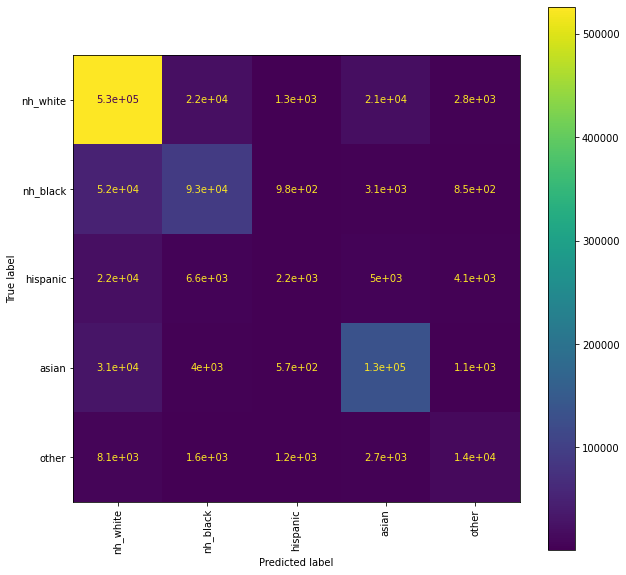

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline  

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [53]:
# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.595703

Test Accuracy of nh_white: 91% (526389/573417)
Test Accuracy of nh_black: 61% (92526/149283)
Test Accuracy of hispanic:  5% (2220/40188)
Test Accuracy of asian: 78% (132658/169034)
Test Accuracy of other: 50% (14180/27822)

Test Accuracy (Overall): 80% (767973/959744)


## Inference

In [54]:
name = "Ward Stephanie"
name_tokens = lineToTensor(name)
inp = name_tokens
print(inp.shape)
out = rnn(inp.unsqueeze(0).to(device))
print(out.shape)
out = torch.argmax(out)
print(out)
print(all_categories[out.item()])

torch.Size([47])
torch.Size([1, 5])
tensor(2, device='cuda:0')
hispanic


## Load and Test

In [55]:
test_rnn = LSTM(vocab_size, n_hidden, n_categories)
test_rnn.load_state_dict(torch.load('lstm_FullName_pytorch.pt'))
test_rnn.to(device)

LSTM(
  (embedding): Embedding(57, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Testing: 100%|██████████| 7498/7498 [01:43<00:00, 72.60it/s]


              precision    recall  f1-score   support

       asian       0.81      0.78      0.80    169045
    hispanic       0.36      0.06      0.10     40185
    nh_black       0.73      0.62      0.67    149285
    nh_white       0.82      0.92      0.87    573402
       other       0.62      0.51      0.56     27827

    accuracy                           0.80    959744
   macro avg       0.67      0.58      0.60    959744
weighted avg       0.78      0.80      0.78    959744

Test Loss: 0.595720

Test Accuracy of nh_white: 91% (526377/573402)
Test Accuracy of nh_black: 61% (92526/149285)
Test Accuracy of hispanic:  5% (2220/40185)
Test Accuracy of asian: 78% (132662/169045)
Test Accuracy of other: 50% (14182/27827)

Test Accuracy (Overall): 80% (767967/959744)


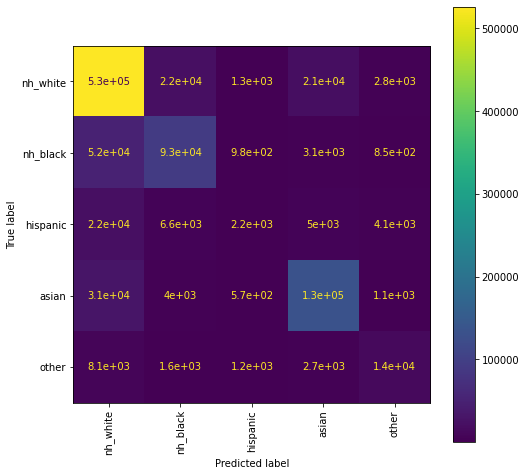

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = test_rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix    
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

import matplotlib.pyplot as plt
%matplotlib inline  

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [57]:
!du -sh lstm_FullName_pytorch.pt

552K	lstm_FullName_pytorch.pt
